The transformer architecture enables the identification of attention points, which are indicators of the importance given to each of the elements from the input sequences of the TFT architecture that are used to forecast MOSFET ageing. Focusing on 70-step ahead predictions (_i.e._, 30% of training data), this notebook shows the attention curves for the Tests 9, 11 and 36.

Note that 70-step ahead predictions are performed through concatenation. That is, 4 step-ahead predictions are used in an iterative manner to reach 70 step-ahead predictions.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, mse
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.explainability import TFTExplainer
import warnings
import time
from scipy.optimize import curve_fit

from pathlib import Path

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

# Read Data

In [3]:
# before starting, we define some constants
num_samples = 500  #samples per forecast
# default quantiles for QuantileRegression
quantiles = [    0.01,    0.025,    0.05,    0.1,    0.15,    0.2,    0.25,    0.3,    0.4,    0.5,    0.6,    0.7,    0.75,    0.8,    0.85,    0.9,    0.95,    0.975,    0.99]
#Figure Size
figsize = (9, 6)
#Percentiles for plotting
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"
#Path to directory containing the csvs
DATAPATH = Path("./RDSon_CSVs/")   #Make sure this path matches the location of the preprocessed Tests csvs.
test11_df = pd.read_csv(DATAPATH / "Test_11_RDSon.csv", names=['rdson'])
test09_df = pd.read_csv(DATAPATH / "Test_09_RDSon.csv", names=['rdson'])
test36_df = pd.read_csv(DATAPATH / "Test_36_RDSon.csv", names=['rdson'])
print("Test 11 shape: ", test11_df.shape)
print("Test 09 shape: ", test09_df.shape)
print("Test 36 shape: ", test36_df.shape)
#convert Test DFs into TimeSeries
test11_series = TimeSeries.from_dataframe(test11_df)
test09_series = TimeSeries.from_dataframe(test09_df)
test36_series = TimeSeries.from_dataframe(test36_df)
#Normalize TimeSeries from 0 to 1
transformer_11, transformer_09, transformer_36 = Scaler(), Scaler(), Scaler()
test_11_transformed = transformer_11.fit_transform(test11_series)
test_11_transformed_trimmed = test_11_transformed[0:93] #remove padding
test_09_transformed = transformer_09.fit_transform(test09_series)
test_09_transformed_trimmed = test_09_transformed[0:90] #remove padding
test_36_transformed = transformer_36.fit_transform(test36_series)

Test 11 shape:  (100, 1)
Test 09 shape:  (100, 1)
Test 36 shape:  (100, 1)


# AUX Functions

In [4]:
def func(t, a, b):
    #Function used to fit portions of the Test's curves to a straight line
    return a * t + b

In [5]:
def split_n_fitlines(test_series):
    #This function splits the series in chunks of 20 samples, then for each chunk it fits a straight line through least-squares
    y1 = test_series.slice(0, 20)
    y2 = test_series.slice(20, 40)
    y3 = test_series.slice(40, 60)
    y4 = test_series.slice(60, 80)
    y5 = test_series.slice(80, 100)
    timeVector1 = np.arange(0, 20).astype(float)
    timeVector2 = np.arange(20, 40).astype(float)
    timeVector3 = np.arange(40, 60).astype(float)
    timeVector4 = np.arange(60, 80).astype(float)
    timeVector5 = np.arange(80, 100).astype(float)
    #Set y values
    y1 = y1.pd_dataframe().to_numpy(copy=True, dtype=float)
    y2 = y2.pd_dataframe().to_numpy(copy=True, dtype=float)
    y3 = y3.pd_dataframe().to_numpy(copy=True, dtype=float)
    y4 = y4.pd_dataframe().to_numpy(copy=True, dtype=float)
    y5 = y5.pd_dataframe().to_numpy(copy=True, dtype=float)
    popt1, _ = curve_fit(func, timeVector1.flatten('F'), y1.flatten('F'),
                         p0=(1, y1.flatten()[1]))
    popt2, _ = curve_fit(func, timeVector1.flatten('F'), y2.flatten('F'),
                         p0=(1, y2.flatten()[1]))
    popt3, _ = curve_fit(func, timeVector1.flatten('F'), y3.flatten('F'),
                         p0=(1, y3.flatten()[1]))
    popt4, _ = curve_fit(func, timeVector1.flatten('F'), y4.flatten('F'),
                         p0=(1, y4.flatten()[1]))
    popt5, _ = curve_fit(func, timeVector1.flatten('F'), y5.flatten('F'),
                         p0=(1, y5.flatten()[1]))
    vals1 = popt1[0] * timeVector1 + popt1[1]
    vals2 = popt2[0] * timeVector2 + popt2[1]
    vals3 = popt3[0] * timeVector3 + popt3[1]
    vals4 = popt4[0] * timeVector4 + popt4[1]
    vals5 = popt5[0] * timeVector5 + popt5[1]
    cov_vector1 = TimeSeries.from_values(vals1, columns=["fitted_curve"])
    cov_vector2 = TimeSeries.from_values(vals2, columns=["fitted_curve"])
    cov_vector3 = TimeSeries.from_values(vals3, columns=["fitted_curve"])
    cov_vector4 = TimeSeries.from_values(vals4, columns=["fitted_curve"])
    cov_vector5 = TimeSeries.from_values(vals5, columns=["fitted_curve"])
    cov_vector = cov_vector1.concatenate(cov_vector2, ignore_time_axis=True)
    cov_vector = cov_vector.concatenate(cov_vector3, ignore_time_axis=True)
    cov_vector = cov_vector.concatenate(cov_vector4, ignore_time_axis=True)
    cov_vector = cov_vector.concatenate(cov_vector5, ignore_time_axis=True)
    comps_transformer = Scaler()
    cov_transf = comps_transformer.fit_transform(cov_vector)

    return cov_transf

# Covariate Creation

## Fitted Line every 20 samples

In [6]:
t36_lines = split_n_fitlines(test36_series)
t36_lines = t36_lines.with_columns_renamed(col_names=["fitted_curve"],
                                           col_names_new=["Test36"])
t11_lines = split_n_fitlines(test11_series)
t11_lines = t11_lines.with_columns_renamed(col_names=["fitted_curve"],
                                           col_names_new=["Test11"])
t09_lines = split_n_fitlines(test09_series)
t09_lines = t09_lines.with_columns_renamed(col_names=["fitted_curve"],
                                           col_names_new=["Test09"])

## Time IDX

In [7]:
# create integer index covariate series
example_RI = pd.RangeIndex(start=0, stop=100, step=1)
covariates = TimeSeries.from_times_and_values(
    times=example_RI,
    values=np.arange(len(example_RI)),
    columns=["linear_increase"],
).astype(np.float32)

scaler_covs = Scaler()
covariates_transformed = scaler_covs.fit_transform(covariates)

# Covariates Vectors definition

In [9]:
#Covariate Test 9
covariate_t09 = covariates_transformed.stack(t11_lines).stack(t36_lines)
#Covariate Test 11
covariate_t11 = covariates_transformed.stack(t09_lines).stack(t36_lines)
#Covariate Test 36
covariate_t36  = covariates_transformed.stack(t09_lines).stack(t11_lines)

# Models Definition and Fit

In [10]:
#Define hyperparameters of the TFT
input_chunk_length = 20
forecast_horizon = 4
num_epochs = 400
#Hyperparams for model D Architecture
hidden_sizes = 256
lstms = 4
att_heads = 4

In [11]:
#Define the TFT model
model_T36 = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hidden_sizes,
    lstm_layers=lstms,
    num_attention_heads=att_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=num_epochs,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(quantiles=quantiles),
    random_state=42,
    force_reset=True
)
#Fit the TFT model with Test 9 and 11 data to then evaluate on Test 36
model_T36.fit(series=[test_09_transformed, test_11_transformed],
              future_covariates=[covariate_t36, covariate_t36],
              verbose=True)

Training: |          | 0/? [00:00<?, ?it/s]

TFTModel(output_chunk_shift=0, hidden_size=256, lstm_layers=4, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[list[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=20, output_chunk_length=4, batch_size=16, n_epochs=400, add_encoders=None, random_state=42, force_reset=True)

In [14]:
#Define the TFT model
model_T11 = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hidden_sizes,
    lstm_layers=lstms,
    num_attention_heads=att_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=num_epochs,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(quantiles=quantiles),
    random_state=42,
    force_reset=True
)
#Fit the TFT model with Test 9 and 36 data to then evaluate on Test 11
model_T11.fit(series=[test_09_transformed, test_36_transformed],
              future_covariates=[covariate_t11, covariate_t11],
              verbose=True)

Training: 0it [00:00, ?it/s]

TFTModel(hidden_size=256, lstm_layers=4, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=20, output_chunk_length=4, batch_size=16, n_epochs=400, add_encoders=None, random_state=42, force_reset=True)

In [15]:
#Define the TFT model
model_T09 = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hidden_sizes,
    lstm_layers=lstms,
    num_attention_heads=att_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=num_epochs,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(quantiles=quantiles),
    random_state=42,
    force_reset=True
)
#Fit the TFT model with Test 11 and 36 data to then evaluate on Test 11
model_T09.fit(series=[test_11_transformed, test_36_transformed],
              future_covariates=[covariate_t09, covariate_t09],
              verbose=True)

Training: 0it [00:00, ?it/s]

TFTModel(hidden_size=256, lstm_layers=4, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=20, output_chunk_length=4, batch_size=16, n_epochs=400, add_encoders=None, random_state=42, force_reset=True)

# Explainability

## Test 36

In [13]:
#Obtain Attention curves for the 70 Steps-ahead case
#As metioned before, the 70 steps-ahead forecast is obtained by the concatenation of successive 4 steps-ahead forecasts.
#Therefore, this cell captures the attention given by the model to each time index for each of these successive 4 steps-ahead
#forecasts.
attentions_T36_70 = []
time_idxs_T36_70 = []
test_No = 36
steps_No = 70
for k in range(29,len(test_36_transformed)-forecast_horizon,forecast_horizon):
    print(k)
    x1 = np.arange(k-19, k + 5, 1) #compute new time indexes for each iteration
    t36_tfd_tr_x, _ = test_36_transformed.split_after(k) #split the time series
    explainer_T36 = TFTExplainer(model=model_T36, background_series=t36_tfd_tr_x,
                                 background_future_covariates=covariate_t36)
    explainability_T36 = explainer_T36.explain() #obtain the explainability object
    attention = explainability_T36.get_attention().mean(axis=1) #computes the mean along each of the attention heads.
    time_idxs_T36_70.append(x1) #save time indexes to a list
    attentions_T36_70.append(attention) #save attention values to a list

29


Predicting: |          | 0/? [00:00<?, ?it/s]

33


Predicting: |          | 0/? [00:00<?, ?it/s]

37


Predicting: |          | 0/? [00:00<?, ?it/s]

41


Predicting: |          | 0/? [00:00<?, ?it/s]

45


Predicting: |          | 0/? [00:00<?, ?it/s]

49


Predicting: |          | 0/? [00:00<?, ?it/s]

53


Predicting: |          | 0/? [00:00<?, ?it/s]

57


Predicting: |          | 0/? [00:00<?, ?it/s]

61


Predicting: |          | 0/? [00:00<?, ?it/s]

65


Predicting: |          | 0/? [00:00<?, ?it/s]

69


Predicting: |          | 0/? [00:00<?, ?it/s]

73


Predicting: |          | 0/? [00:00<?, ?it/s]

77


Predicting: |          | 0/? [00:00<?, ?it/s]

81


Predicting: |          | 0/? [00:00<?, ?it/s]

85


Predicting: |          | 0/? [00:00<?, ?it/s]

89


Predicting: |          | 0/? [00:00<?, ?it/s]

93


Predicting: |          | 0/? [00:00<?, ?it/s]

In [22]:
#Here the Max. Attention points are obtained for the 70 Steps-ahead Attention curves
max_idxs_T36_70 = []
for k in range(len(time_idxs_T36_70)):
    idx = np.argmax(attentions_T36_70[k].values()) #get the max attention value per iteration
    max_idxs_T36_70.append(time_idxs_T36_70[k][idx]) #retrieve the time index that matches that attention value
max_idxs_T36_70

[23, 33, 31, 41, 43, 43, 53, 57, 61, 65, 68, 58, 58, 64, 86, 90, 94]

### 70-Steps Ahead Attn Curves Plot

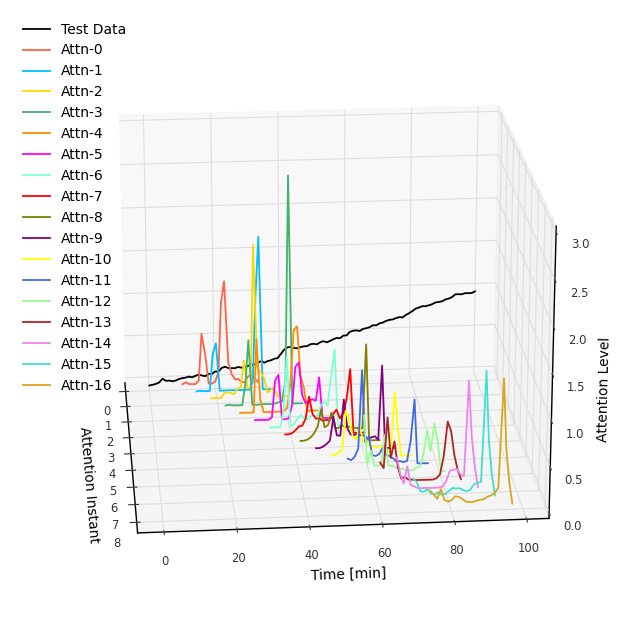

In [25]:
#Plot Attention Curves for the 70 steps-ahead case
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
ax.plot(np.arange(0,len(test_36_transformed)),test_36_transformed.values(), zs=0, zdir='x', label='Test Data')
z_offset = 0.5
colors = ['tomato', 'deepskyblue', 'gold', 'mediumseagreen', 'darkorange',
          'fuchsia', 'aquamarine', 'red', 'olive','purple',
          'yellow', 'royalblue', 'palegreen', 'firebrick', 'violet',
          'turquoise', 'goldenrod']
for k in range(len(time_idxs_T36_70)):
    ax.plot(time_idxs_T36_70[k], attentions_T36_70[k].values(),
            zs=z_offset*k, zdir='x', label='Attn-{}'.format(k), color=colors[k])
ax.set_zlim(0, 3)
ax.set_xlabel('Attention Instant')
ax.set_ylabel('Time [min]')
ax.set_zlabel('Attention Level')
#ax.title.set_text('Attention Curves T{}-70 Steps Ahead'.format(test_No))
ax.view_init(elev=20., azim=-5, roll=0)
ax.legend(loc="upper left", ncols=1)
# Uncomment following lines to save plot. NOTE: Modify Directory
# file_name = "3D_Attention_Plots/Test_{}_AttCur_70_steps".format(test_No)
# plt.savefig(file_name, dpi=800.0)
# file_name = "3D_Attention_Plots/Test_{}_AttCur_70_steps.svg".format(test_No)
# plt.savefig(file_name, dpi=800.0)
plt.show()

### 70-Steps Ahead Attn Max Points Plot

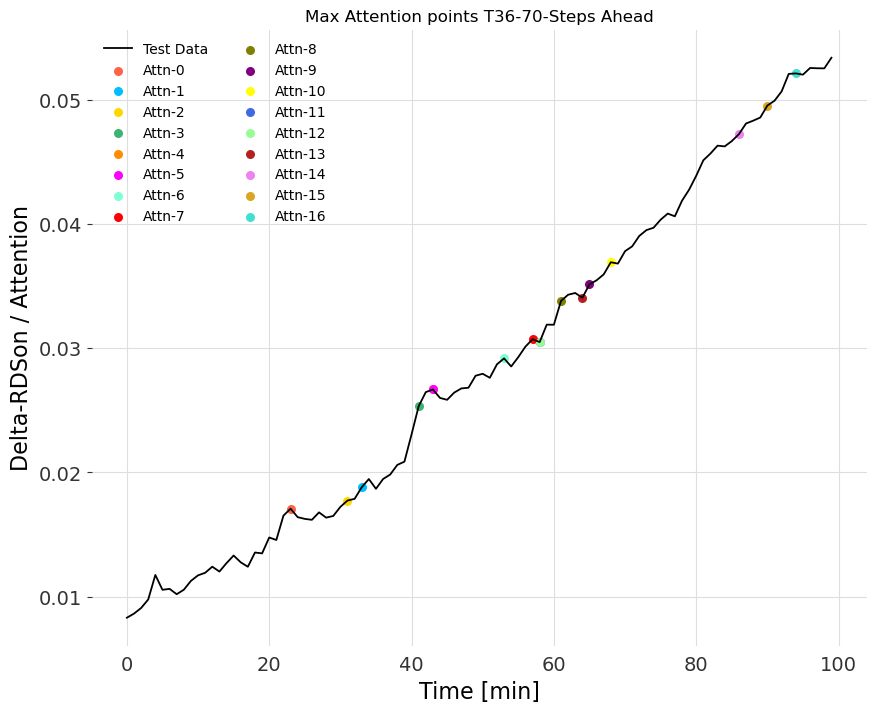

In [23]:
#Plot Delta-RDSon with the Max. Attention points mapped on it for the 70 steps-ahead case
fig = plt.figure(figsize=(10,8))
x_ax = np.arange(0,len(test_36_transformed))
plt.plot(x_ax,
         transformer_36.inverse_transform(test_36_transformed).values(),
         label="Test Data")
for k in range(len(max_idxs_T36_70)):
    plt.scatter(max_idxs_T36_70[k],
                transformer_36.inverse_transform(test_36_transformed).values()[max_idxs_T36_70[k]],
                color=colors[k], label='Attn-{}'.format(k), s=30, marker='o')
# plt.plot(time_idx,
#          attention_means, 'b',
#          linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon / Attention', fontsize=16)
plt.title("Max Attention points T{}-70-Steps Ahead".format(test_No))
plt.legend(ncols=2)
# Uncomment following lines to save plot. NOTE: Modify Directory
# file_name = "3D_Attention_Plots/Test_{}_AttPts_70_steps".format(test_No)
# plt.savefig(file_name, dpi=800.0)
# file_name = "3D_Attention_Plots/Test_{}_AttPts_70_steps.svg".format(test_No)
# plt.savefig(file_name, dpi=800.0)
plt.show()

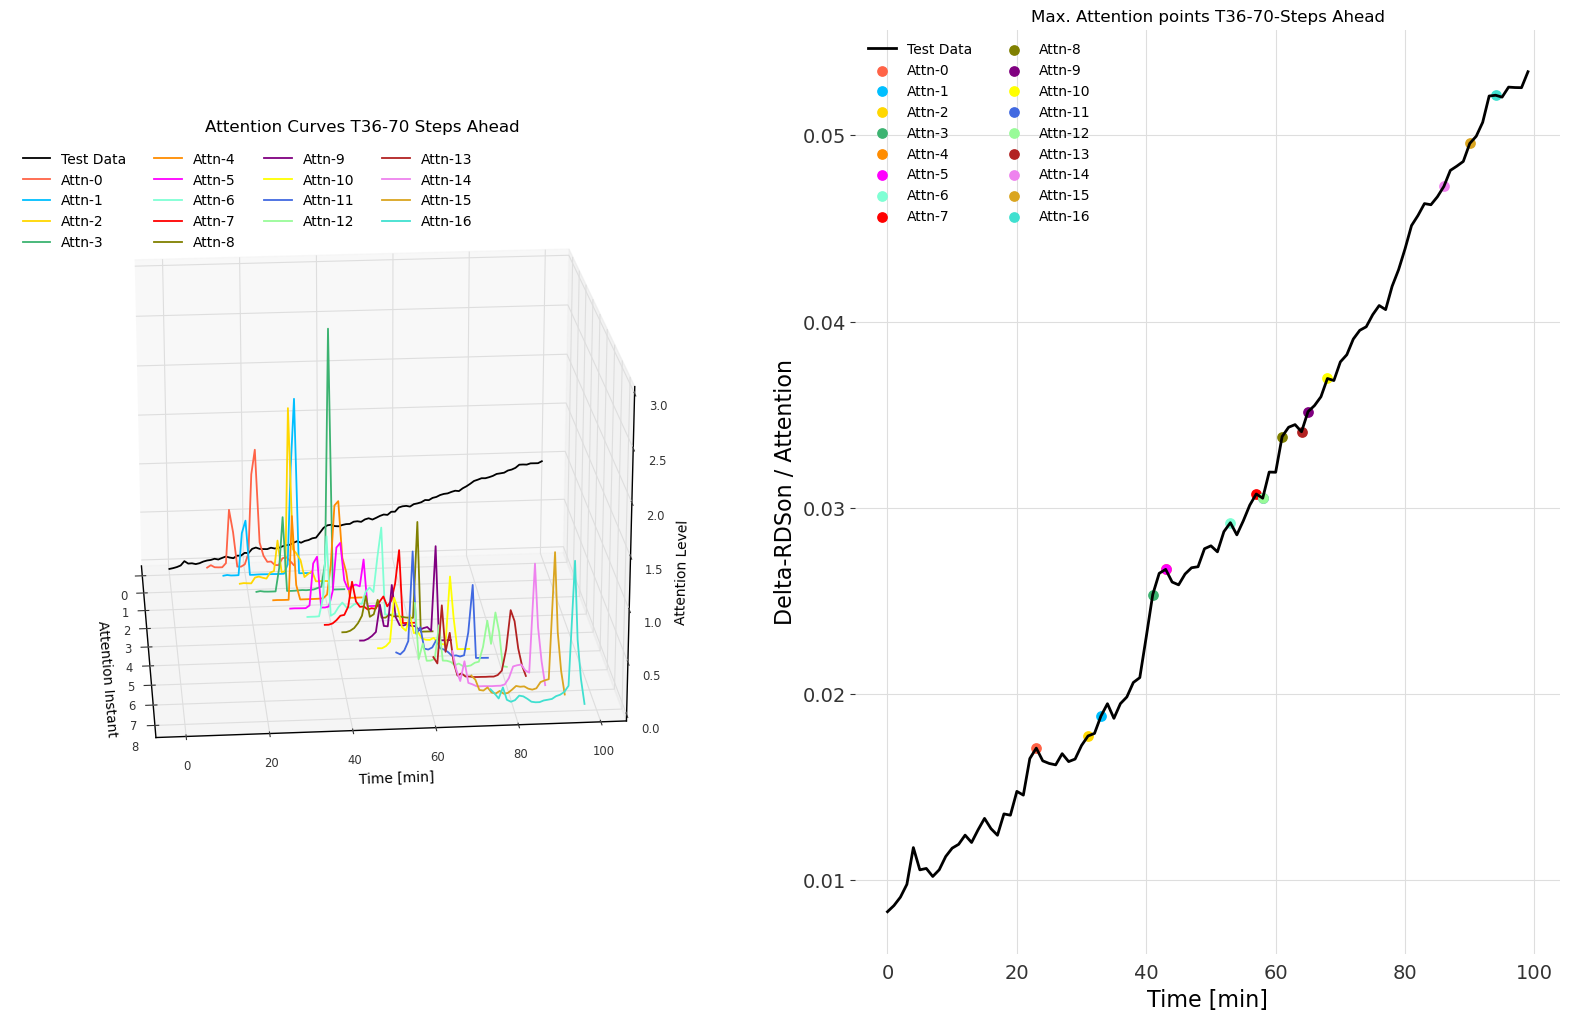

In [41]:
#Plot Attention Curves and Max. Attention Points mapped into Delta-RDSon for the 70-steps ahead
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.plot(np.arange(0,len(test_36_transformed)),test_36_transformed.values(), zs=0, zdir='x', label='Test Data')
z_offset = 0.5
colors = ['tomato', 'deepskyblue', 'gold', 'mediumseagreen', 'darkorange',
          'fuchsia', 'aquamarine', 'red', 'olive','purple',
          'yellow', 'royalblue', 'palegreen', 'firebrick', 'violet',
          'goldenrod', 'turquoise']
for k in range(len(time_idxs_T36_70)):
    ax.plot(time_idxs_T36_70[k], attentions_T36_70[k].values(),
            zs=z_offset*k, zdir='x', label='Attn-{}'.format(k), color=colors[k])


ax4 = fig.add_subplot(1,2,2)
transformer_36.inverse_transform(test_36_transformed).plot(label="Test Data")
for k in range(len(max_idxs_T36_70)):
    plt.scatter(max_idxs_T36_70[k],
                transformer_36.inverse_transform(test_36_transformed).values()[max_idxs_T36_70[k]],
                color=colors[k], label='Attn-{}'.format(k), s=45, marker='o')
# plt.plot(time_idx,
#          attention_means, 'b',
#          linestyle='dashed')
ax4.tick_params(axis='both', which='major', labelsize=14)
ax4.tick_params(axis='both', which='minor', labelsize=10)
ax4.set_xlabel('Time [min]', fontsize=16)
ax4.set_ylabel('Delta-RDSon / Attention', fontsize=16)
ax4.title.set_text("Max. Attention points T{}-70-Steps Ahead".format(test_No))
ax4.legend(ncols=2)

# Make legend, set axes limits and labels
ax.legend(loc="upper left", ncols=4)
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
ax.set_zlim(0, 3)
ax.set_xlabel('Attention Instant')
ax.set_ylabel('Time [min]')
ax.set_zlabel('Attention Level')
ax.title.set_text('Attention Curves T{}-70 Steps Ahead'.format(test_No))

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=20., azim=-5, roll=0)
#plt.title("Test {}-ALL-Steps-Ahead".format(test_No, steps_No))
# Uncomment following lines to save plot. *NOTE: Modify Directory*
# file_name = "3D_Attention_Plots/Test_{}_{}_steps_Cur_MaxP".format(test_No, steps_No)
# plt.savefig(file_name, dpi=800.0)
# file_name = "3D_Attention_Plots/Test_{}_{}_steps_Cur_MaxP.svg".format(test_No, steps_No)
# plt.savefig(file_name, dpi=800.0)
plt.show()

## Test 11

In [ ]:
#Obtain Attention curves for the 70 Steps-ahead case
#As metioned before, the 70 steps-ahead forecast is obtained by the concatenation of successive 4 steps-ahead forecasts.
#Therefore, this cell captures the attention given by the model to each time index for each of these successive 4 steps-ahead
#forecasts.
attentions_T11_70 = []
time_idxs_T11_70 = []
test_No = 11
steps_No = 70
for k in range(29,len(test_11_transformed_trimmed)-forecast_horizon,forecast_horizon):
    print(k)
    x1 = np.arange(k-19, k + 5, 1) #compute new time indexes for each iteration
    t11_tfd_tr_x, _ = test_11_transformed_trimmed.split_after(k) #split the time series
    explainer_T11 = TFTExplainer(model=model_T11, background_series=t11_tfd_tr_x,
                                 background_future_covariates=covariate_t11)
    explainability_T11 = explainer_T11.explain() #obtain the explainability object
    attention = explainability_T11.get_attention().mean(axis=1) #computes the mean along each of the attention heads.
    time_idxs_T11_70.append(x1) #save time indexes to a list
    attentions_T11_70.append(attention) #save attention values to a list

In [16]:
#Here the Max. Attention points are obtained for the 70 Steps-ahead Attention curves
max_idxs_T11_70 = []
for k in range(len(time_idxs_T11_70)):
    idx = np.argmax(attentions_T11_70[k].values()) #get the max attention value per iteration
    max_idxs_T11_70.append(time_idxs_T11_70[k][idx]) #retrieve the time index that matches that attention value
max_idxs_T11_70

[14, 19, 23, 23, 31, 35, 38, 41, 59, 52, 66, 58, 65, 69, 72]

### 70-Steps Attn Curves Plot

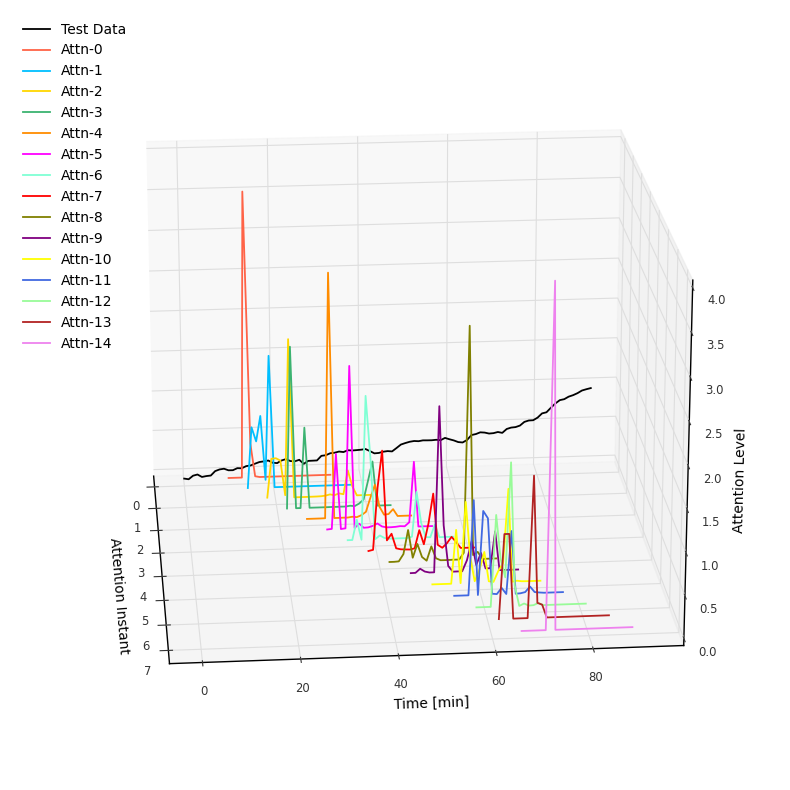

In [20]:
#Plot Attention Curves for the 70 steps-ahead case
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.plot(np.arange(0,len(test_11_transformed_trimmed)),test_11_transformed_trimmed.values(),
        zs=0, zdir='x', label='Test Data')
z_offset = 0.5
colors = ['tomato', 'deepskyblue', 'gold', 'mediumseagreen', 'darkorange',
          'fuchsia', 'aquamarine', 'red', 'olive','purple',
          'yellow', 'royalblue', 'palegreen', 'firebrick', 'violet',
          'goldenrod', 'turquoise']
for k in range(len(time_idxs_T11_70)):
    ax.plot(time_idxs_T11_70[k], attentions_T11_70[k].values(), zs=z_offset*k, zdir='x',
            label='Attn-{}'.format(k), color=colors[k])

# Make legend, set axes limits and labels
ax.legend(loc="upper left")
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
ax.set_zlim(0, 4)
ax.set_xlabel('Attention Instant')
ax.set_ylabel('Time [min]')
ax.set_zlabel('Attention Level')
# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=20., azim=-5, roll=0)
# Uncomment following lines to save plot. *NOTE: Modify Directory*
# file_name = "3D_Attention_Plots/Test_{}_AttCur_70_steps".format(test_No)
# plt.savefig(file_name, dpi=800.0)
# file_name = "3D_Attention_Plots/Test_{}_AttCur_70_steps.svg".format(test_No)
# plt.savefig(file_name, dpi=800.0)
plt.show()

### 70-Steps Attn Max Pts Plot

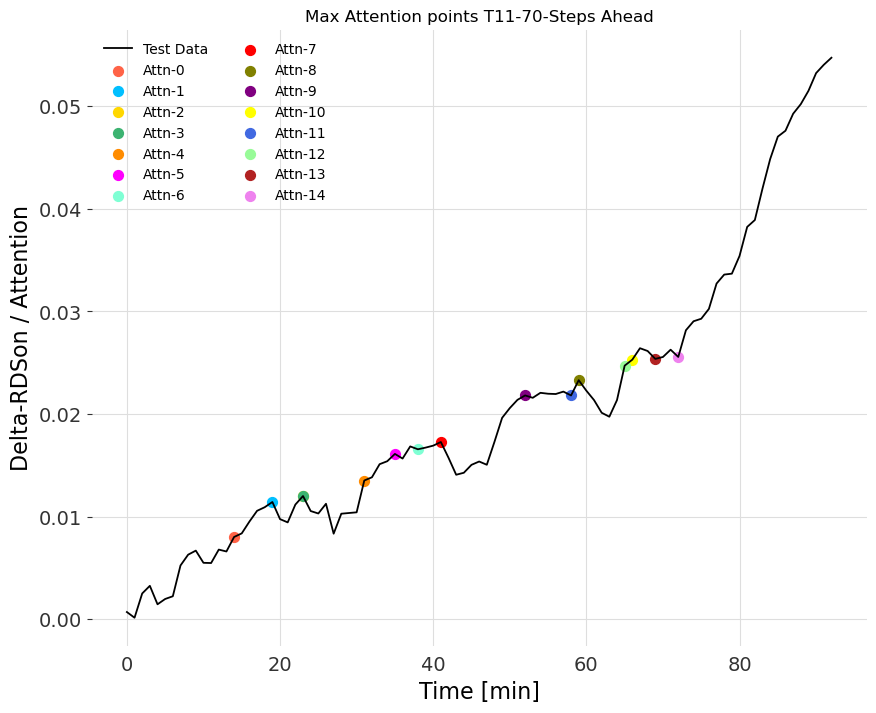

In [18]:
#Plot Delta-RDSon with the Max. Attention points mapped on it for the 70 steps-ahead case
fig = plt.figure(figsize=(10,8))
x_ax = np.arange(0,len(test_11_transformed_trimmed))
plt.plot(x_ax,
         transformer_11.inverse_transform(test_11_transformed_trimmed).values(),
         label="Test Data")
for k in range(len(max_idxs_T11_70)):
    plt.scatter(max_idxs_T11_70[k],
                transformer_11.inverse_transform(test_11_transformed_trimmed).values()[max_idxs_T11_70[k]],
                color=colors[k], label='Attn-{}'.format(k), s=50, marker='o')
# plt.plot(time_idx,
#          attention_means, 'b',
#          linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon / Attention', fontsize=16)
plt.title("Max Attention points T{}-70-Steps Ahead".format(test_No))
plt.legend(ncols=2)
# Uncomment following lines to save plot. *NOTE: Modify Directory*
# file_name = "3D_Attention_Plots/Test_{}_AttPts_70_steps".format(test_No)
# plt.savefig(file_name, dpi=800.0)
# file_name = "3D_Attention_Plots/Test_{}_AttPts_70_steps.svg".format(test_No)
# plt.savefig(file_name, dpi=800.0)
plt.show()

## Test 09

In [ ]:
#Obtain Attention curves for the 70 Steps-ahead case
#As metioned before, the 70 steps-ahead forecast is obtained by the concatenation of successive 4 steps-ahead forecasts.
#Therefore, this cell captures the attention given by the model to each time index for each of these successive 4 steps-ahead
#forecasts.
attentions_T09_70 = []
time_idxs_T09_70 = []
test_No = 9
steps_No = 70
for k in range(29,len(test_09_transformed_trimmed)-forecast_horizon,forecast_horizon):
    print(k)
    x1 = np.arange(k-19, k + 5, 1) #compute new time indexes for each iteration
    t09_tfd_tr_x, _ = test_09_transformed_trimmed.split_after(k) #split the time series
    explainer_T09 = TFTExplainer(model=model_T09, background_series=t09_tfd_tr_x,
                                 background_future_covariates=covariate_t09)
    explainability_T09 = explainer_T09.explain() #obtain the explainability object
    attention = explainability_T09.get_attention().mean(axis=1) #computes the mean along each of the attention heads.
    time_idxs_T09_70.append(x1) #save time indexes to a list
    attentions_T09_70.append(attention) #save attention values to a list

In [22]:
#Here the Max. Attention points are obtained for the 70 Steps-ahead Attention curves
max_idxs_T09_70 = []
for k in range(len(time_idxs_T09_70)):
    idx = np.argmax(attentions_T09_70[k].values()) #get the max attention value per iteration
    max_idxs_T09_70.append(time_idxs_T09_70[k][idx]) #retrieve the time index that matches that attention value
max_idxs_T09_70

[24, 27, 30, 33, 38, 39, 46, 48, 54, 57, 62, 70, 74, 77, 79]

### 70-Steps Attn Curves Plot

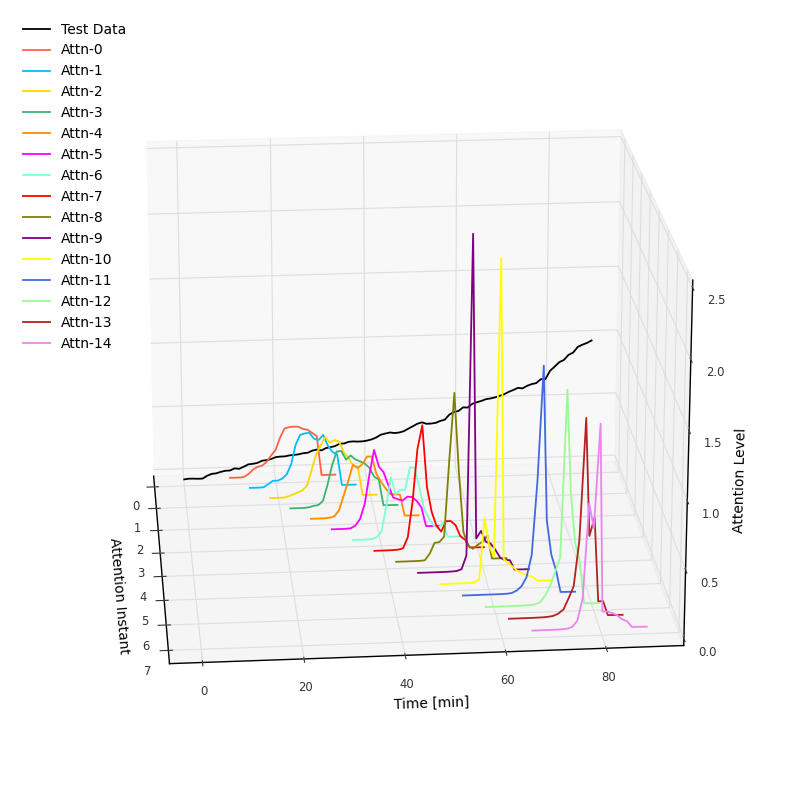

In [23]:
#Plot Attention Curves for the 70 steps-ahead case
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.plot(np.arange(0,len(test_09_transformed_trimmed)),test_09_transformed_trimmed.values(),
        zs=0, zdir='x', label='Test Data')
z_offset = 0.5
colors = ['tomato', 'deepskyblue', 'gold', 'mediumseagreen', 'darkorange',
          'fuchsia', 'aquamarine', 'red', 'olive','purple',
          'yellow', 'royalblue', 'palegreen', 'firebrick', 'violet',
          'goldenrod', 'turquoise']
for k in range(len(time_idxs_T09_70)):
    ax.plot(time_idxs_T09_70[k], attentions_T09_70[k].values(), zs=z_offset*k, zdir='x', label='Attn-{}'.format(k), color=colors[k])

# Make legend, set axes limits and labels
ax.legend(loc="upper left")
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
ax.set_zlim(0, 2.5)
ax.set_xlabel('Attention Instant')
ax.set_ylabel('Time [min]')
ax.set_zlabel('Attention Level')
# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=20., azim=-5, roll=0)
# Uncomment following lines to save plot. *NOTE: Modify Directory*
# file_name = "3D_Attention_Plots/Test_{}_AttCur_70_steps".format(test_No)
# plt.savefig(file_name, dpi=800.0)
# file_name = "3D_Attention_Plots/Test_{}_AttCur_70_steps.svg".format(test_No)
# plt.savefig(file_name, dpi=800.0)
plt.show()

### 70-Steps Attn Max Pts Plot

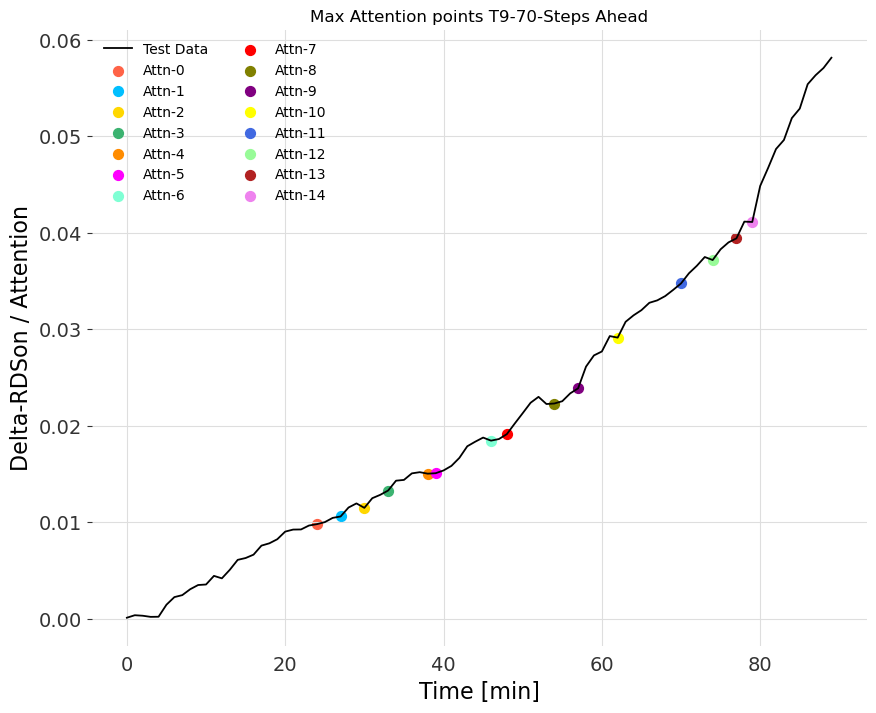

In [24]:
#Plot Delta-RDSon with the Max. Attention points mapped on it for the 70 steps-ahead case
fig = plt.figure(figsize=(10,8))
x_ax = np.arange(0,len(test_09_transformed_trimmed))
plt.plot(x_ax,
         transformer_09.inverse_transform(test_09_transformed_trimmed).values(),
         label="Test Data")
for k in range(len(max_idxs_T09_70)):
    plt.scatter(max_idxs_T09_70[k],
                transformer_09.inverse_transform(test_09_transformed_trimmed).values()[max_idxs_T09_70[k]],
                color=colors[k], label='Attn-{}'.format(k), s=50, marker='o')
# plt.plot(time_idx,
#          attention_means, 'b',
#          linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon / Attention', fontsize=16)
plt.title("Max Attention points T{}-70-Steps Ahead".format(test_No))
plt.legend(ncols=2)
# Uncomment following lines to save plot. *NOTE: Modify Directory*
# file_name = "3D_Attention_Plots/Test_{}_AttPts_70_steps".format(test_No)
# plt.savefig(file_name, dpi=800.0)
# file_name = "3D_Attention_Plots/Test_{}_AttPts_70_steps.svg".format(test_No)
# plt.savefig(file_name, dpi=800.0)
plt.show()

# END